# Credit Card Default - Kaggle
The intention of this mini project on a classification problem is to explore the data, engineer new features, do the preprocessing, perform feature selection, build the optimized model and score it on the test data under 8 hours. I will record my lessons learned and what I could have done better for future projects at the end of the notebook.

In [144]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#from pandas_profiling import ProfileReport

from catboost import CatBoostClassifier
from lightgbm.sklearn import LGBMClassifier

from sklearn.compose import make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import (
    cross_validate,
    train_test_split,
    RandomizedSearchCV,
    GridSearchCV
)
from sklearn.feature_selection import RFECV, SelectFromModel
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.metrics import classification_report, recall_score, f1_score, precision_score, roc_auc_score

import altair as alt
alt.renderers.enable('mimetype')
alt.data_transformers.enable("data_server")

import seaborn as sns
%matplotlib inline

<br><br>

## 1. Data - Prediction problem
<hr>


This is a classification problem of predicting whether a credit card client will default or not. For this problem, I will use [Default of Credit Card Clients Dataset](https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset). This dataset contains information on default payments, demographic factors, credit data, history of payment, and bill statements of credit card clients in Taiwan from April 2005 to September 2005. In this data set, there are 30,000 examples and 24 features, and the goal is to estimate whether a person will default (fail to pay) their credit card bills; this column is labeled "default.payment.next.month" in the data. The rest of the columns can be used as features. 


I will spend some time understanding the problem and what each feature means and will write a few sentences on my initial thoughts on the problem and the dataset. 

There are 25 variables:

ID: ID of each client  ----- **I will be setting this as the index.**  
LIMIT_BAL: Amount of given credit in NT dollars (includes individual and family/supplementary credit  
SEX: Gender (1=male, 2=female)  
EDUCATION: (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)  
MARRIAGE: Marital status (1=married, 2=single, 3=others)  
AGE: Age in years  
PAY_0: Repayment status in September, 2005 (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, … 8=payment delay for eight months, 9=payment delay for nine months and above)  
PAY_2: Repayment status in August, 2005 (scale same as above)  
PAY_3: Repayment status in July, 2005 (scale same as above)  
PAY_4: Repayment status in June, 2005 (scale same as above)  
PAY_5: Repayment status in May, 2005 (scale same as above)  
PAY_6: Repayment status in April, 2005 (scale same as above)  
BILL_AMT1: Amount of bill statement in September, 2005 (NT dollar)  
BILL_AMT2: Amount of bill statement in August, 2005 (NT dollar)  
BILL_AMT3: Amount of bill statement in July, 2005 (NT dollar)  
BILL_AMT4: Amount of bill statement in June, 2005 (NT dollar)  
BILL_AMT5: Amount of bill statement in May, 2005 (NT dollar)  
BILL_AMT6: Amount of bill statement in April, 2005 (NT dollar)  
PAY_AMT1: Amount of previous payment in September, 2005 (NT dollar)  
PAY_AMT2: Amount of previous payment in August, 2005 (NT dollar)  
PAY_AMT3: Amount of previous payment in July, 2005 (NT dollar)  
PAY_AMT4: Amount of previous payment in June, 2005 (NT dollar)  
PAY_AMT5: Amount of previous payment in May, 2005 (NT dollar)  
PAY_AMT6: Amount of previous payment in April, 2005 (NT dollar)  


default.payment.next.month: Default payment (1=yes, 0=no)


In [2]:
credit = pd.read_csv("../downloads/UCI_Credit_Card.csv", index_col=0)

I will be renaming the target column for ease of access:

In [69]:
credit.rename({"default.payment.next.month": "default"}, axis=1, inplace=True)

There seems to be a replication of `unknown` category for `EDUCATION` column. I will replace 6's with 5's because they represent the same thing.

In [79]:
credit['EDUCATION'] = credit['EDUCATION'].replace(6, 5)

In [4]:
credit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   LIMIT_BAL  30000 non-null  float64
 1   SEX        30000 non-null  int64  
 2   EDUCATION  30000 non-null  int64  
 3   MARRIAGE   30000 non-null  int64  
 4   AGE        30000 non-null  int64  
 5   PAY_0      30000 non-null  int64  
 6   PAY_2      30000 non-null  int64  
 7   PAY_3      30000 non-null  int64  
 8   PAY_4      30000 non-null  int64  
 9   PAY_5      30000 non-null  int64  
 10  PAY_6      30000 non-null  int64  
 11  BILL_AMT1  30000 non-null  float64
 12  BILL_AMT2  30000 non-null  float64
 13  BILL_AMT3  30000 non-null  float64
 14  BILL_AMT4  30000 non-null  float64
 15  BILL_AMT5  30000 non-null  float64
 16  BILL_AMT6  30000 non-null  float64
 17  PAY_AMT1   30000 non-null  float64
 18  PAY_AMT2   30000 non-null  float64
 19  PAY_AMT3   30000 non-null  float64
 20  PAY_AM

There seems to be no missing data.

In [5]:
credit.isna().any(axis=0)

LIMIT_BAL    False
SEX          False
EDUCATION    False
MARRIAGE     False
AGE          False
PAY_0        False
PAY_2        False
PAY_3        False
PAY_4        False
PAY_5        False
PAY_6        False
BILL_AMT1    False
BILL_AMT2    False
BILL_AMT3    False
BILL_AMT4    False
BILL_AMT5    False
BILL_AMT6    False
PAY_AMT1     False
PAY_AMT2     False
PAY_AMT3     False
PAY_AMT4     False
PAY_AMT5     False
PAY_AMT6     False
default      False
dtype: bool

<br><br>

## 2. Data splitting 
<hr>

I am splitting the data into train and test portions with a 0.3 to 0.7 ratio due to the large size of data and my computer not being able to handle this size.


In [6]:
X_train, X_test, y_train, y_test = train_test_split(credit.drop("default", axis=1), credit["default"], test_size=0.7, random_state=2021)

In [7]:
X_train.shape

(9000, 23)

In [8]:
y_train.shape

(9000,)

<br><br>

## 3. EDA 
<hr>




In [13]:
X_train.describe(include="all")

LIMIT_BAL          SEX    EDUCATION     MARRIAGE          AGE  \
count    9000.000000  9000.000000  9000.000000  9000.000000  9000.000000   
mean   168467.333333     1.607333     1.852333     1.554778    35.567111   
std    129931.202528     0.488371     0.790174     0.522097     9.339288   
min     10000.000000     1.000000     0.000000     0.000000    21.000000   
25%     50000.000000     1.000000     1.000000     1.000000    28.000000   
50%    140000.000000     2.000000     2.000000     2.000000    34.000000   
75%    240000.000000     2.000000     2.000000     2.000000    42.000000   
max    780000.000000     2.000000     6.000000     3.000000    79.000000   

             PAY_0       PAY_2        PAY_3        PAY_4        PAY_5  ...  \
count  9000.000000  9000.00000  9000.000000  9000.000000  9000.000000  ...   
mean     -0.030556    -0.13500    -0.181778    -0.233111    -0.280111  ...   
std       1.119814     1.20381     1.204439     1.185108     1.151143  ...   
min      -2.000000    -2.00000    -2.000000    -2.000000    -2.000000  ...   
25%      -1.000000    -1.00000    -1.000000    -1.000000    -1.000000  ...   
50%       0.000000     0.00000     0.000000     0.000000     0.000000  ...   
75%       0.000000     0.00000     0.000000     0.000000     0.000000  ...   
max       8.000000     8.00000     8.000000     8.000000     8.000000  ...   

           BILL_AMT3      BILL_AMT4      BILL_AMT5      BILL_AMT6  \
count    9000.000000    9000.000000    9000.000000    9000.000000   
mean    46583.804111   42683.756556   39960.152667   38625.997000   
std     67996.294931   62944.552831   60222.609347   58595.764786   
min    -15910.000000  -65167.000000  -61372.000000  -51443.000000   
25%      2500.000000    2149.000000    1666.500000    1204.500000   
50%     19924.500000   18943.000000   17906.000000   16936.000000   
75%     60195.000000   54174.500000   49882.750000   49071.750000   
max    693131.000000  569034.000000  587067.000000  568638.000000   

            PAY_AMT1      PAY_AMT2       PAY_AMT3       PAY_AMT4  \
count    9000.000000  9.000000e+03    9000.000000    9000.000000   
mean     5672.442667  6.039652e+03    5061.282333    4837.572333   
std     18096.877377  2.201342e+04   17017.782234   16494.113941   
min         0.000000  0.000000e+00       0.000000       0.000000   
25%       948.000000  8.497500e+02     390.000000     283.000000   
50%      2108.000000  2.007000e+03    1793.500000    1500.000000   
75%      5003.250000  5.000000e+03    4525.000000    4000.000000   
max    873552.000000  1.215471e+06  889043.000000  621000.000000   

            PAY_AMT5       PAY_AMT6  
count    9000.000000    9000.000000  
mean     4738.722778    5035.599333  
std     14546.564903   16795.182782  
min         0.000000       0.000000  
25%       264.000000     113.500000  
50%      1500.000000    1497.500000  
75%      4008.500000    4000.000000  
max    417990.000000  443001.000000  

[8 rows x 23 columns]

In [21]:
y_train.value_counts(normalize=True)

0    0.774667
1    0.225333
Name: default, dtype: float64

In [29]:
train_df = pd.concat([X_train, y_train], axis=1)

train_df

LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
ID                                                                            
16801   230000.0    1          2         1   34     -1     -1     -1     -1   
4692     80000.0    2          1         2   25     -1     -1     -2     -2   
17824    30000.0    1          3         2   25      2      0      0      0   
3584     10000.0    1          3         1   51      2      2      2      2   
1470    160000.0    2          3         2   29      1     -2     -2     -2   
...          ...  ...        ...       ...  ...    ...    ...    ...    ...   
2670     10000.0    1          5         1   43     -1      0      0      0   
17537   160000.0    2          2         2   42     -1     -1     -1     -1   
6202    260000.0    1          1         1   38     -1     -1     -1     -1   
27990   360000.0    2          2         1   30      0      0     -2     -2   
25717   120000.0    2          2         2   40      1     -2     -2     -2   

       PAY_5  ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  \
ID            ...                                                        
16801     -1  ...     3475.0     1791.0     2993.0       0.0    2196.0   
4692      -2  ...        0.0        0.0        0.0       0.0       0.0   
17824      0  ...    26347.0    27508.0    30118.0    1500.0    1500.0   
3584       0  ...     5820.0     6026.0     7680.0    2500.0     300.0   
1470      -2  ...     2065.0        0.0      500.0       0.0    4150.0   
...      ...  ...        ...        ...        ...       ...       ...   
2670      -2  ...        0.0        0.0        0.0    2537.0    1000.0   
17537     -1  ...      552.0    19367.0       -1.0   40991.0    2252.0   
6202      -1  ...     1175.0      888.0     4186.0    1211.0    6818.0   
27990     -2  ...    -5377.0    -2377.0     -377.0     500.0       0.0   
25717     -2  ...     -200.0        0.0     8360.0       0.0       0.0   

       PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6  default  
ID                                                      
16801    3485.0    1796.0    3002.0    2601.0        0  
4692        0.0       0.0       0.0       0.0        0  
17824    1439.0    1600.0    3200.0       0.0        1  
3584        0.0     300.0    1774.0     284.0        1  
1470     2065.0       0.0     500.0       0.0        1  
...         ...       ...       ...       ...      ...  
2670        0.0       0.0       0.0       0.0        1  
17537     553.0   19425.0       0.0     649.0        0  
6202     1180.0     892.0    4207.0    6175.0        1  
27990    2000.0    3000.0    2000.0    3000.0        0  
25717       0.0     200.0    8360.0       0.0        0  

[9000 rows x 24 columns]

The target seems unbalanced (23% to 77%), but it is not very bad to force us to use balanced models. However, we could include balancing as a hyperparameter to optimize in our models.


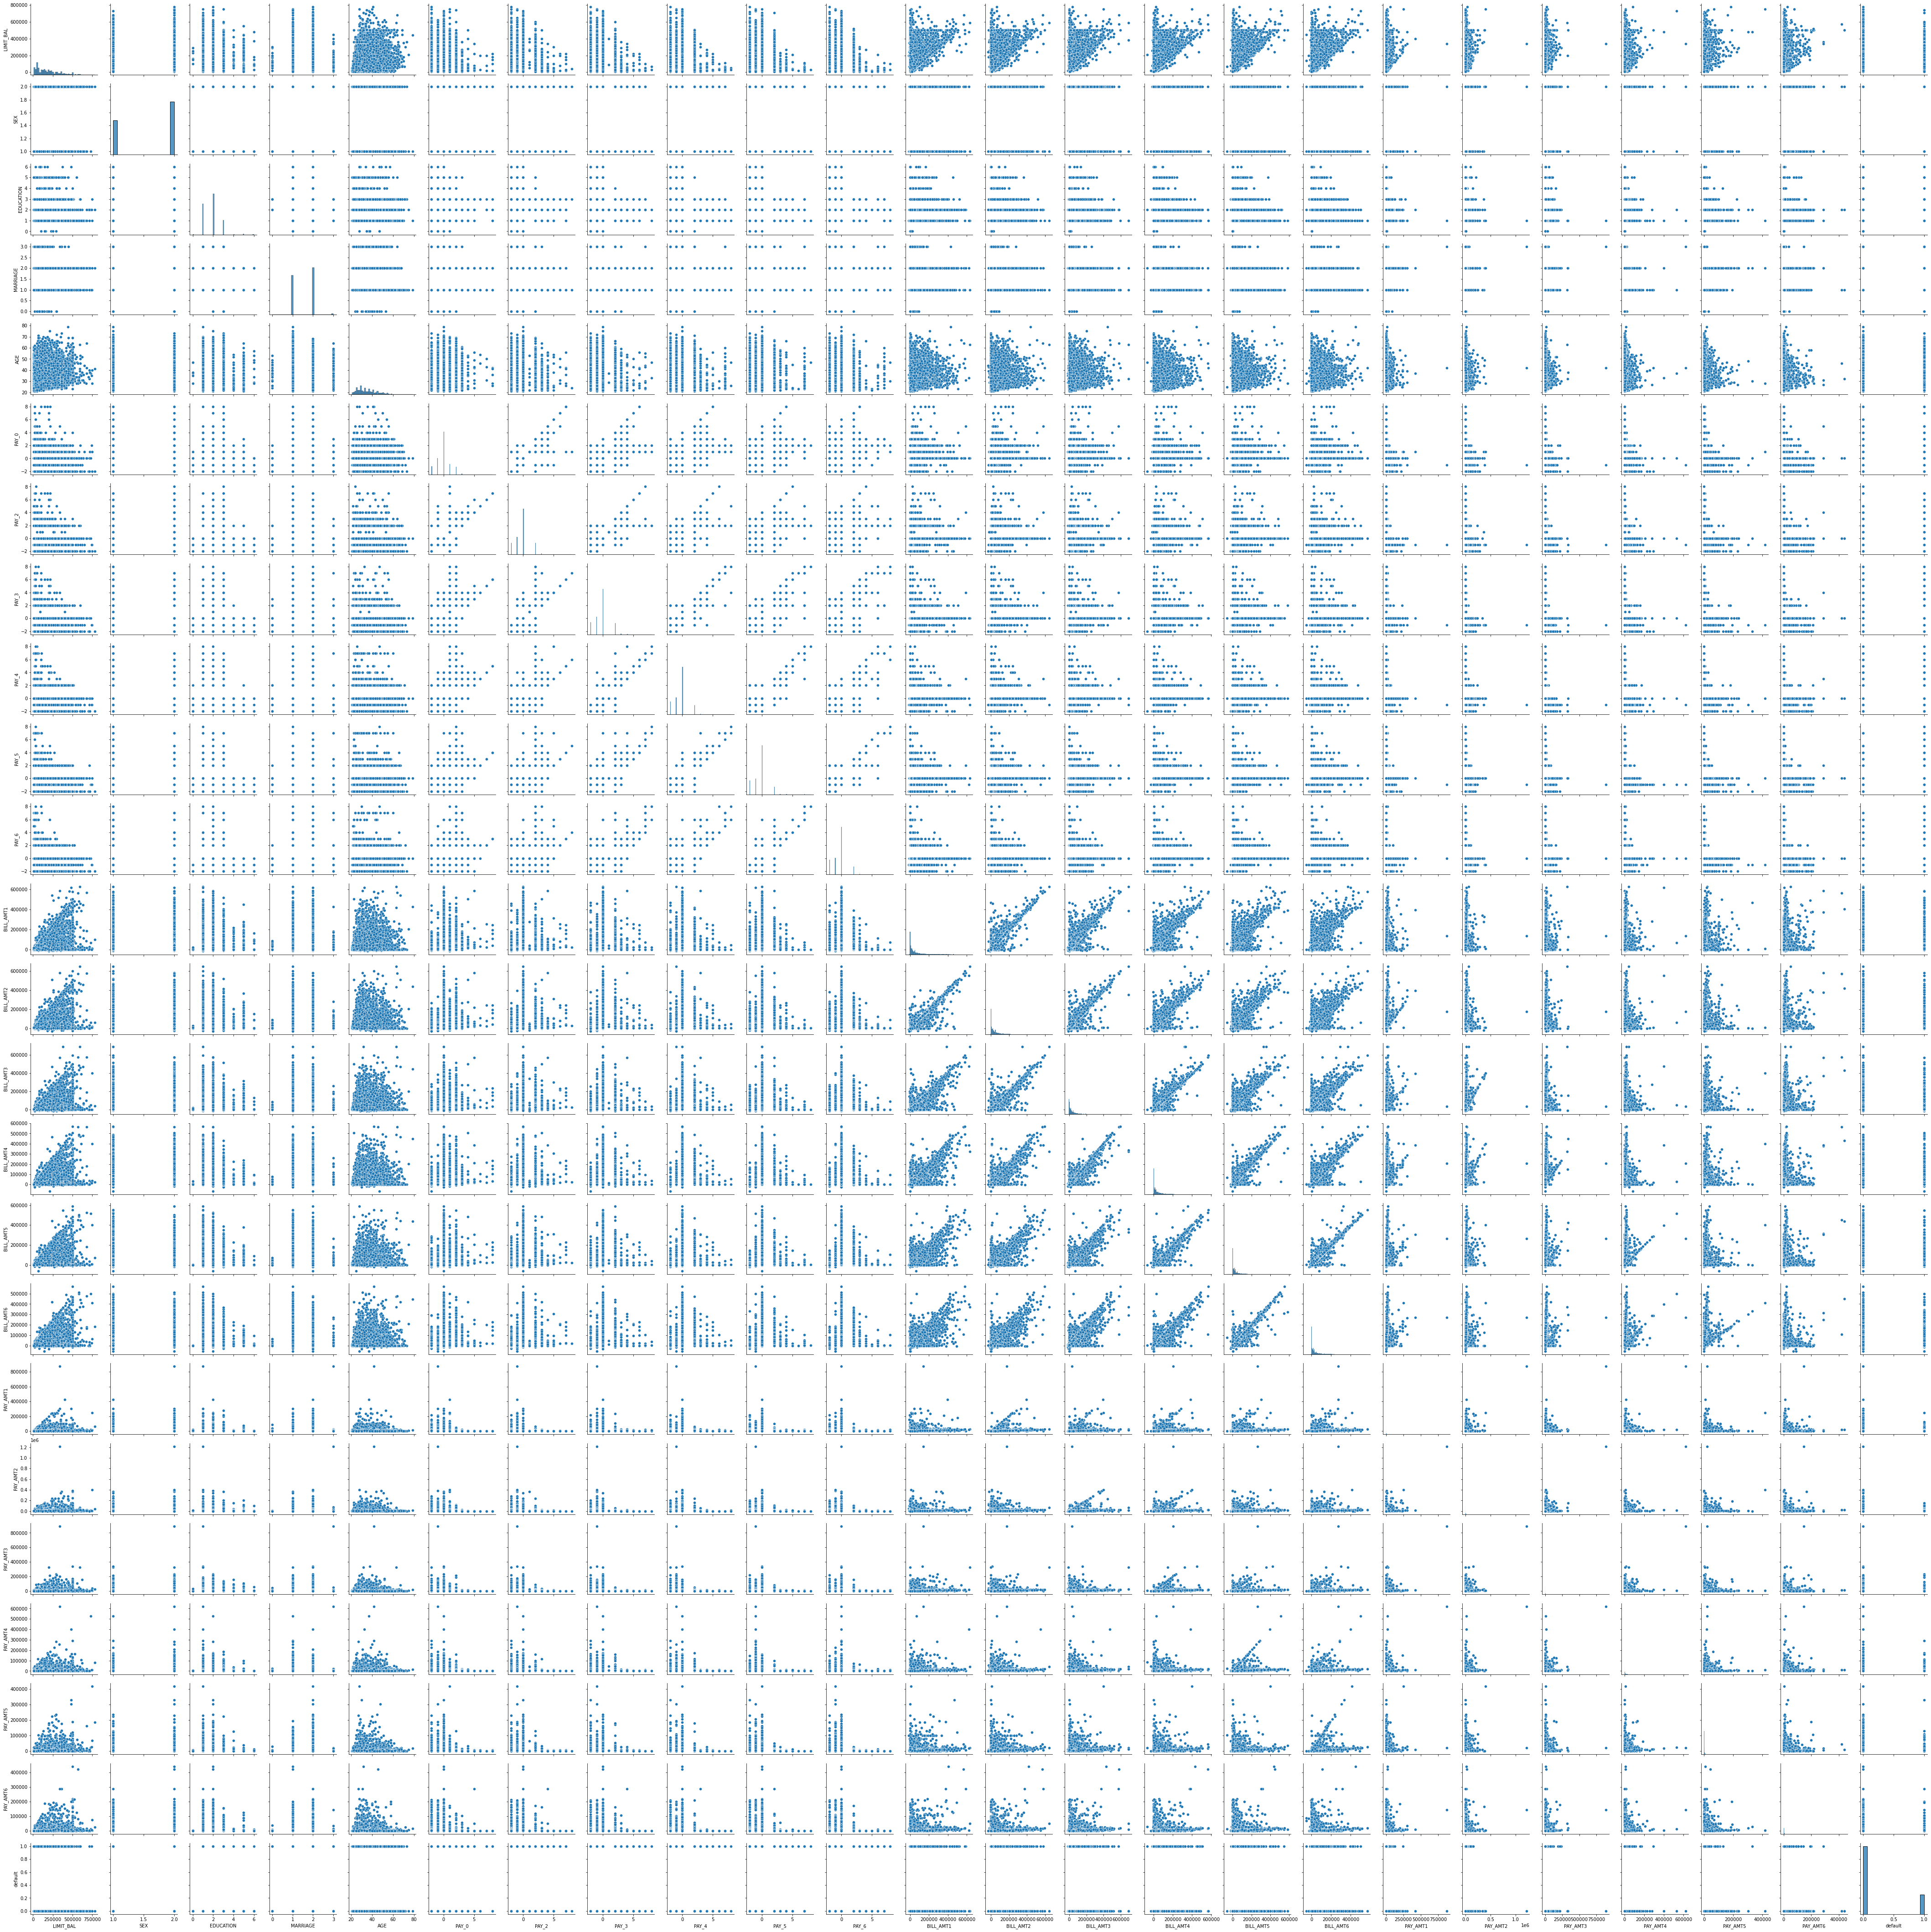

In [10]:
train_df = pd.concat([X_train, y_train], axis=1)
sns.pairplot(train_df)

This is very hard to see, but what is important is that there are some collinearity between some of these features (e.g. PAY_0 to PAY_5), and we need to be using regularization to overcome this.

Next I will see the distribution of all numeri

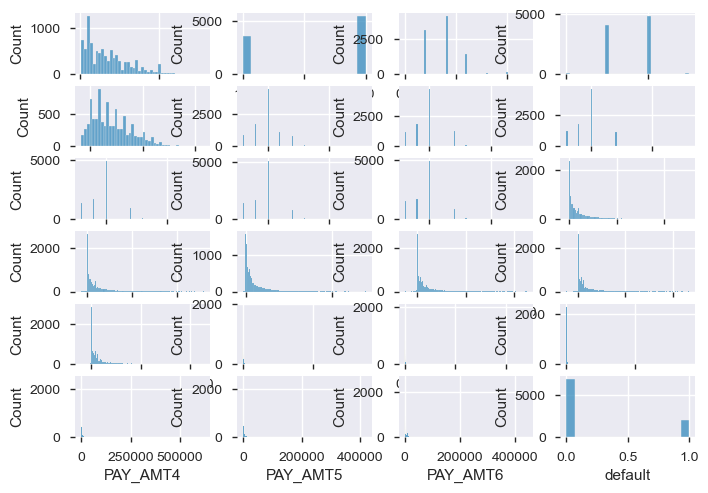

In [41]:
import matplotlib.pyplot as plt
nrows=6
ncols=4
fig, axes = plt.subplots(nrows=nrows, ncols=ncols)

for i, column in enumerate(train_df.columns):
    sns.histplot(train_df[column],ax=axes[i//ncols,i%ncols])

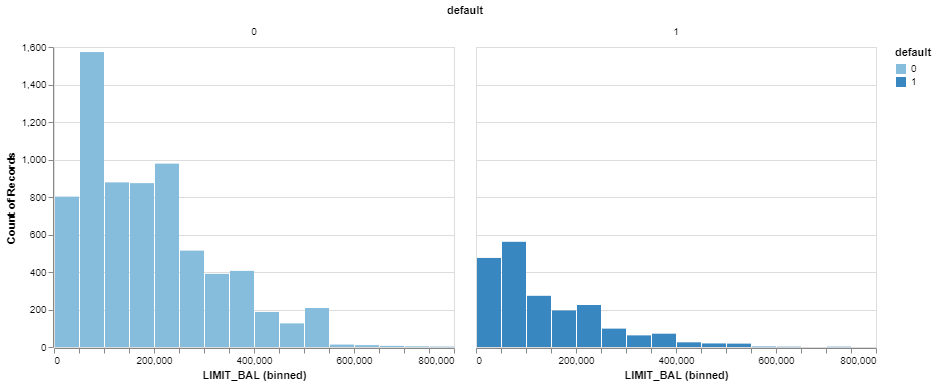

In [57]:
columns = train_df.columns.tolist()

alt.Chart(train_df).mark_bar().encode(
    x=alt.X('LIMIT_BAL', bin=alt.Bin(maxbins=20)),
    y=alt.Y('count()'),
    color='default:O'
).facet('default')

LIMIT_BAL which is the amount of credit given seems to be very right-skewed.

- The skewedness of data will cause the regression line to not best represent the underlying weights, and it might be necessary to use L1 (absolute mean error) as the cost function instead of L2 (root mean square error) to minimize the effect of penalizing squared differences. Some columns including id (already used as index) could be dropped. 

### Scoring Metric
- One might argue that they will be picking recall as their metric for this analysis since for the case of credit card default detection we want to increase the percentage of prediction of default cases (True positive) over all cases which will truly default in the future (True positive + False negative). However, I am picking accuracy over recall because for a credit bureau it is also important not to lose customer, and therefore, they need to keep both True Positive (TP) and True Negative (TN) at maximum.

In [123]:
scoring = 'accuracy'  # (TP + TN) / all

<br><br>

## 4. Feature engineering 
<hr>


I am creating six extra columns by dividing Amount of bill statement (`BILL_PCT#`) per month over the amount of given credit to each person (`LIMIT_BAL`) to see if the percentage over or under the credit limit would trigger any behaviour on the target population, and therefore, predict future credit defaults.

In [59]:
for i in range(1, 7):
    X_train['BILL_PCT' + str(i)] = X_train["BILL_AMT" + str(i)] / X_train['LIMIT_BAL']

In [63]:
X_train.head(3)

LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
ID                                                                            
16801   230000.0    1          2         1   34     -1     -1     -1     -1   
4692     80000.0    2          1         2   25     -1     -1     -2     -2   
17824    30000.0    1          3         2   25      2      0      0      0   

       PAY_5  ...  PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6  BILL_PCT1  \
ID            ...                                                      
16801     -1  ...    3485.0    1796.0    3002.0    2601.0   0.005843   
4692      -2  ...       0.0       0.0       0.0       0.0   0.020900   
17824      0  ...    1439.0    1600.0    3200.0       0.0   0.780700   

       BILL_PCT2  BILL_PCT3  BILL_PCT4  BILL_PCT5  BILL_PCT6  
ID                                                            
16801  -0.000026   0.009522   0.015109   0.007787   0.013013  
4692    0.000000   0.000000   0.000000   0.000000   0.000000  
17824   0.807600   0.844367   0.878233   0.916933   1.003933  

[3 rows x 29 columns]

<br><br>

## 5. Preprocessing and transformations
<hr>


I am identifying different feature types and the transformations I would apply on each feature type, and will then define a column transformer.

In [82]:
X_train.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'BILL_PCT1',
       'BILL_PCT2', 'BILL_PCT3', 'BILL_PCT4', 'BILL_PCT5', 'BILL_PCT6'],
      dtype='object')

In [86]:
credit['PAY_2'].unique()

array([ 2,  0, -1, -2,  3,  5,  7,  4,  1,  6,  8], dtype=int64)

In [113]:
drop = []
categorical = [
    "SEX",
    "EDUCATION",
    "MARRIAGE",
    "PAY_0",
    "PAY_2",
    "PAY_3",
    "PAY_4",
    "PAY_5",
    "PAY_6",
]  # values of PAY_# are between -2 to 9
numeric = [
    "LIMIT_BAL",
    "AGE",
    "BILL_AMT1",
    "BILL_AMT2",
    "BILL_AMT3",
    "BILL_AMT4",
    "BILL_AMT5",
    "BILL_AMT6",
    "PAY_AMT1",
    "PAY_AMT2",
    "PAY_AMT3",
    "PAY_AMT4",
    "PAY_AMT5",
    "PAY_AMT6",
]
passthrough = [
    "BILL_PCT1",
    "BILL_PCT2",
    "BILL_PCT3",
    "BILL_PCT4",
    "BILL_PCT5",
    "BILL_PCT6",
]  

assert len(drop + categorical + numeric + passthrough) == len(X_train.columns.tolist())

In [114]:
preprocessor = make_column_transformer(
    ("drop", drop),
    (OneHotEncoder(handle_unknown="ignore"), categorical),
    (StandardScaler(),numeric),
    ("passthrough", passthrough)
)

<br><br>

## 6. Baseline model 
<hr>

1. Try `scikit-learn`'s baseline model and report results.

In [106]:

def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation
    from MDS lecture
    
    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [124]:
results = dict()

dummy_pipe = make_pipeline(preprocessor, DummyClassifier())
results["Dummy Classifier"] = mean_std_cross_val_scores(dummy_pipe, X_train, y_train, return_train_score=True, cv=5, scoring=scoring)
pd.DataFrame(results)

Dummy Classifier
fit_time     0.021 (+/- 0.003)
score_time   0.007 (+/- 0.004)
test_score   0.775 (+/- 0.000)
train_score  0.775 (+/- 0.000)

<br><br>

## 7. Linear models 
<hr>

I will try a linear model as a first real attempt. I will then carry out hyperparameter tuning to explore different values for the regularization hyperparameter. Finally I will report cross-validation scores along with standard deviation and a summary of results.

In [133]:
lr_pipe = make_pipeline(preprocessor, LogisticRegression(max_iter=2000, random_state=2021))
results["Logistic Regression"] = mean_std_cross_val_scores(lr_pipe, X_train, y_train, return_train_score=True, cv=5, scoring=scoring)
pd.DataFrame(results)

Dummy Classifier Logistic Regression
fit_time     0.021 (+/- 0.003)   0.271 (+/- 0.032)
score_time   0.007 (+/- 0.004)   0.011 (+/- 0.007)
test_score   0.775 (+/- 0.000)   0.820 (+/- 0.004)
train_score  0.775 (+/- 0.000)   0.823 (+/- 0.001)

In [134]:
lr_params = {
    "logisticregression__C": list(np.logspace(-3,3,7)),
    "logisticregression__class_weight": ['balanced', None]
}
hyper_lr = GridSearchCV(lr_pipe, param_grid=lr_params, scoring=scoring, cv=5, return_train_score=True)

In [135]:
hyper_lr.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('drop',
                                                                         'drop',
                                                                         []),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['SEX',
                                                                          'EDUCATION',
                                                                          'MARRIAGE',
                                                                          'PAY_0',
                                                                          'PAY_2',
                                                         

In [136]:
hyper_lr.best_params_

{'logisticregression__C': 10.0, 'logisticregression__class_weight': None}

In [137]:
hyper_lr.best_score_

0.8204444444444444

In [142]:
best_C = hyper_lr.best_params_['logisticregression__C']
best_class_weight = hyper_lr.best_params_['logisticregression__class_weight']

tuned_lr = make_pipeline(preprocessor, LogisticRegression(random_state=2021, max_iter=2000, C=best_C, class_weight=best_class_weight))
results["Tuned Logistic Reg"] = mean_std_cross_val_scores(tuned_lr, X_train, y_train, return_train_score=True, cv=5, scoring=scoring)
pd.DataFrame(results)

Dummy Classifier Logistic Regression Tuned Logistic Regression  \
fit_time     0.021 (+/- 0.003)   0.271 (+/- 0.032)         0.587 (+/- 0.065)   
score_time   0.007 (+/- 0.004)   0.011 (+/- 0.007)         0.003 (+/- 0.007)   
test_score   0.775 (+/- 0.000)   0.820 (+/- 0.004)         0.820 (+/- 0.004)   
train_score  0.775 (+/- 0.000)   0.823 (+/- 0.001)         0.824 (+/- 0.000)   

            Tuned Logistic Reg  
fit_time     1.269 (+/- 0.261)  
score_time   0.019 (+/- 0.007)  
test_score   0.820 (+/- 0.004)  
train_score  0.824 (+/- 0.000)

_According to the above, although our hyperparameter tuning has selected a C value of 10 over the default value of 1, we can see that the crossvalidation score (`test_score` in the table above) has not improved._

<br><br>

## 8. Different models 
<hr>

I will try 3 other models aside from a linear model. I will summarize my results in terms of overfitting/underfitting and fit and score times to see if I can beat a linear model.

- Since the size of the data is not very big (<100K) and our dataframe is dense (not sparse) I will give SVM a try to see if it can identify any non-linear patterns. 
- I won't be using Naive Bayes model for this exercise. The major weakness of NB is that the predictive accuracy is highly correlated with the assumption of class conditional independence. This assumption simplifies computation. In the case of this dataset, however, dependencies exist between multiple variables. 
- I will be using Random forest as a catch all for decision trees.
- Between LGBM classifier and Catboost classifier, I will also try both and pick one for further hyperparameter tuning.

Note: Running this cell will take upwards of 5 minutes.

In [145]:
models = {
    "SVC": make_pipeline(preprocessor, SVC(kernel='rbf')),
    "Random Forest": make_pipeline(
        preprocessor, RandomForestClassifier(random_state=2021)
    ),
    "LGBM": make_pipeline(
        preprocessor,
        LGBMClassifier(
            random_state=2021,
            verbose=0,
            force_col_wise=True,
        ),
    ),
}

for name, model in models.items():
    results[name] = mean_std_cross_val_scores(
        model, X_train, y_train, return_train_score=True, cv=5, scoring=scoring
    )

pd.DataFrame(results)

Dummy Classifier Logistic Regression Tuned Logistic Regression  \
fit_time     0.021 (+/- 0.003)   0.271 (+/- 0.032)         0.587 (+/- 0.065)   
score_time   0.007 (+/- 0.004)   0.011 (+/- 0.007)         0.003 (+/- 0.007)   
test_score   0.775 (+/- 0.000)   0.820 (+/- 0.004)         0.820 (+/- 0.004)   
train_score  0.775 (+/- 0.000)   0.823 (+/- 0.001)         0.824 (+/- 0.000)   

            Tuned Logistic Reg                SVC      Random Forest  \
fit_time     1.269 (+/- 0.261)  7.074 (+/- 0.262)  3.507 (+/- 0.109)   
score_time   0.019 (+/- 0.007)  1.767 (+/- 0.456)  0.119 (+/- 0.011)   
test_score   0.820 (+/- 0.004)  0.818 (+/- 0.004)  0.815 (+/- 0.005)   
train_score  0.824 (+/- 0.000)  0.825 (+/- 0.001)  1.000 (+/- 0.000)   

                          LGBM  
fit_time     0.566 (+/- 0.008)  
score_time   0.051 (+/- 0.002)  
test_score   0.816 (+/- 0.003)  
train_score  0.898 (+/- 0.002)

I have not been able to beat the linear model (Logistic Regression) using the three new models. In terms of fit time and performance LGBM Classifier seems to be the best of the three added models followed by Random Forest and I will choose both for further tuning and ensemble models. SVC and Random Forest have very long fit times, and when it comes to scoring time, SVC is the the worst of all as expected. Seeing that none of the three added models come close to the score time and CV score (test_score) for Logistic Regression, it would not be rational to use any of these 3 new models unless they improve massively when optimized.  
There are signs of overfitting for Random forest as the train score is 1 and its gap with CV score has increased tremendously. This is mainly due to not having max_depth for decision trees which could potentially be optimized through hyperparameter optimization.

Next, I will try a voting and stacking classifier to see if I see any improvements:

In [214]:
estimators = [
    ("logistic_regression", LogisticRegression(max_iter=2000, random_state=2021)),
    ("random_forest", RandomForestClassifier(random_state=2021)),
    (
        "LGBM",
        LGBMClassifier(
            random_state=2021,
            verbose=0,
            force_col_wise=True,
        ),
    ),
]

# defining voting pipe
voting_classifier = VotingClassifier(estimators=estimators, voting="hard")
vote_pipe = make_pipeline(preprocessor, voting_classifier)

# Calculating cross validation results
results["Voting"] = mean_std_cross_val_scores(
    vote_pipe, X_train, y_train, return_train_score=True, cv=5, scoring=scoring
)
pd.DataFrame(results)

Dummy Classifier Logistic Regression Tuned Logistic Regression  \
fit_time     0.021 (+/- 0.003)   0.271 (+/- 0.032)         0.587 (+/- 0.065)   
score_time   0.007 (+/- 0.004)   0.011 (+/- 0.007)         0.003 (+/- 0.007)   
test_score   0.775 (+/- 0.000)   0.820 (+/- 0.004)         0.820 (+/- 0.004)   
train_score  0.775 (+/- 0.000)   0.823 (+/- 0.001)         0.824 (+/- 0.000)   

            Tuned Logistic Reg                SVC      Random Forest  \
fit_time     1.269 (+/- 0.261)  7.074 (+/- 0.262)  3.507 (+/- 0.109)   
score_time   0.019 (+/- 0.007)  1.767 (+/- 0.456)  0.119 (+/- 0.011)   
test_score   0.820 (+/- 0.004)  0.818 (+/- 0.004)  0.815 (+/- 0.005)   
train_score  0.824 (+/- 0.000)  0.825 (+/- 0.001)  1.000 (+/- 0.000)   

                          LGBM             Voting            Stacking  \
fit_time     0.566 (+/- 0.008)  1.989 (+/- 0.047)  22.909 (+/- 1.350)   
score_time   0.051 (+/- 0.002)  0.126 (+/- 0.002)   0.161 (+/- 0.008)   
test_score   0.816 (+/- 0.003)  0.820 (+/- 0.002)   0.822 (+/- 0.003)   
train_score  0.898 (+/- 0.002)  0.900 (+/- 0.001)   0.881 (+/- 0.008)   

            Voting Feat. Select  
fit_time      3.382 (+/- 0.179)  
score_time    0.224 (+/- 0.047)  
test_score    0.818 (+/- 0.006)  
train_score   0.886 (+/- 0.002)

In [215]:
# List of estimators is acquired from above
stacking_classifier = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(
        max_iter=2000,
        random_state=2021,
    ),
    cv=5,
)

# Calculating cross validation results
stacking_pipe = make_pipeline(preprocessor, stacking_classifier)
results["Stacking"] = mean_std_cross_val_scores(
    stacking_pipe, X_train, y_train, return_train_score=True, cv=5, scoring=scoring
)
pd.DataFrame(results)

Dummy Classifier Logistic Regression Tuned Logistic Regression  \
fit_time     0.021 (+/- 0.003)   0.271 (+/- 0.032)         0.587 (+/- 0.065)   
score_time   0.007 (+/- 0.004)   0.011 (+/- 0.007)         0.003 (+/- 0.007)   
test_score   0.775 (+/- 0.000)   0.820 (+/- 0.004)         0.820 (+/- 0.004)   
train_score  0.775 (+/- 0.000)   0.823 (+/- 0.001)         0.824 (+/- 0.000)   

            Tuned Logistic Reg                SVC      Random Forest  \
fit_time     1.269 (+/- 0.261)  7.074 (+/- 0.262)  3.507 (+/- 0.109)   
score_time   0.019 (+/- 0.007)  1.767 (+/- 0.456)  0.119 (+/- 0.011)   
test_score   0.820 (+/- 0.004)  0.818 (+/- 0.004)  0.815 (+/- 0.005)   
train_score  0.824 (+/- 0.000)  0.825 (+/- 0.001)  1.000 (+/- 0.000)   

                          LGBM             Voting           Stacking  \
fit_time     0.566 (+/- 0.008)  1.989 (+/- 0.047)  9.907 (+/- 0.243)   
score_time   0.051 (+/- 0.002)  0.126 (+/- 0.002)  0.090 (+/- 0.007)   
test_score   0.816 (+/- 0.003)  0.820 (+/- 0.002)  0.821 (+/- 0.003)   
train_score  0.898 (+/- 0.002)  0.900 (+/- 0.001)  0.883 (+/- 0.008)   

            Voting Feat. Select  
fit_time      3.382 (+/- 0.179)  
score_time    0.224 (+/- 0.047)  
test_score    0.818 (+/- 0.006)  
train_score   0.886 (+/- 0.002)

Seeing the better performance of stacking classifier one might get tempted to select this ensemble for further feature selection and hyperparameter optimization. However, I would go with Voting Classifier due to faster fit time and not much difference in cross validation (test) score.
<br><br>

## 9. Feature selection 
<hr>

I am making some attempts to select relevant features. I won't be trying recursive `RFECV` for this because the voting classifier is already slow. Instead, I will SelectFromModel using Logistic Regression with L1 regularization as a step to select smaller number of features. note that the solver needs to be changed to something like liblinear to allow for the optimizer to work (the default lgbfs solver does not work for L1 regularization). I am setting the reverse of regularization term (C) to a small number to penalize coefficients and force majority of them to zero (increase regularization).

In [216]:
feat_select_pipe = make_pipeline(
    preprocessor,
    SelectFromModel(LogisticRegression(penalty='l1', solver='liblinear', C=0.1, random_state=2021)),
    voting_classifier
)

results["Voting Feat. Select"] = mean_std_cross_val_scores(
    feat_select_pipe, X_train, y_train, return_train_score=True, cv=5, scoring=scoring
)
pd.DataFrame(results)

Dummy Classifier Logistic Regression Tuned Logistic Regression  \
fit_time     0.021 (+/- 0.003)   0.271 (+/- 0.032)         0.587 (+/- 0.065)   
score_time   0.007 (+/- 0.004)   0.011 (+/- 0.007)         0.003 (+/- 0.007)   
test_score   0.775 (+/- 0.000)   0.820 (+/- 0.004)         0.820 (+/- 0.004)   
train_score  0.775 (+/- 0.000)   0.823 (+/- 0.001)         0.824 (+/- 0.000)   

            Tuned Logistic Reg                SVC      Random Forest  \
fit_time     1.269 (+/- 0.261)  7.074 (+/- 0.262)  3.507 (+/- 0.109)   
score_time   0.019 (+/- 0.007)  1.767 (+/- 0.456)  0.119 (+/- 0.011)   
test_score   0.820 (+/- 0.004)  0.818 (+/- 0.004)  0.815 (+/- 0.005)   
train_score  0.824 (+/- 0.000)  0.825 (+/- 0.001)  1.000 (+/- 0.000)   

                          LGBM             Voting           Stacking  \
fit_time     0.566 (+/- 0.008)  1.989 (+/- 0.047)  9.907 (+/- 0.243)   
score_time   0.051 (+/- 0.002)  0.126 (+/- 0.002)  0.090 (+/- 0.007)   
test_score   0.816 (+/- 0.003)  0.820 (+/- 0.002)  0.821 (+/- 0.003)   
train_score  0.898 (+/- 0.002)  0.900 (+/- 0.001)  0.883 (+/- 0.008)   

            Voting Feat. Select  
fit_time      1.452 (+/- 0.062)  
score_time    0.139 (+/- 0.007)  
test_score    0.818 (+/- 0.006)  
train_score   0.886 (+/- 0.002)

In [217]:
feat_select_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('drop', 'drop', []),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['SEX', 'EDUCATION',
                                                   'MARRIAGE', 'PAY_0', 'PAY_2',
                                                   'PAY_3', 'PAY_4', 'PAY_5',
                                                   'PAY_6']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['LIMIT_BAL', 'AGE',
                                                   'BILL_AMT1', 'BILL_AMT2',
                                                   'BILL_AMT3', 'BILL_AMT4',
                                                   'BILL_AMT5', 'BILL_AMT6',...
 

In [218]:
feat_select_pipe.named_steps['selectfrommodel'].n_features_in_

96

In [219]:
feat_select_pipe.named_steps['votingclassifier'].n_features_in_

29

With the above feature selection technique, I have reduced the number of input features to a third (from 96 to 29) by keeping the same crossvalidation score while reducing the fit time. This will make the next step, hyperparameter optimzation, very faster.

<br><br>

## 10. Hyperparameter optimization
<hr>
I will be referencing the same feat_select_pipe as above for this section.

In [220]:
LGBMClassifier()

array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])

In [223]:
hyper_params = {
    "votingclassifier__logistic_regression__C": np.logspace(-4, 2, 7),
    "votingclassifier__logistic_regression__class_weight": ['balanced', None],
    "votingclassifier__random_forest__max_depth": 5 * np.arange(1, 6,),
    "votingclassifier__random_forest__class_weight": ['balanced', None],
    "votingclassifier__LGBM__learning_rate": [0.05, 0.1, 0.15, 0.2],
    
}
    
tune_voting = RandomizedSearchCV(feat_select_pipe, param_distributions=hyper_params, n_iter=10, scoring=scoring, cv=5)
tune_voting.fit(X_train, y_train)
tune_voting.best_params_

{'votingclassifier__random_forest__max_depth': 15,
 'votingclassifier__random_forest__class_weight': None,
 'votingclassifier__logistic_regression__class_weight': 'balanced',
 'votingclassifier__logistic_regression__C': 10.0}

In [37]:
tuned_voting = make_pipeline(
        preprocessor,
        LGBMRegressor(
            random_state=2021,
            verbose=0,
            force_col_wise=True,
            boosting_type=tune_lgbm.best_params_['lgbmregressor__boosting_type'] ,
            learning_rate=tune_lgbm.best_params_['lgbmregressor__learning_rate']
        )
)

results["Tuned voting"] = mean_std_cross_val_scores(tuned_voting, X_train, y_train, return_train_score=True, cv=5, scoring=scoring)
pd.DataFrame(results)

Dummy Regressor               Ridge         Tuned Ridge  \
fit_time      0.171 (+/- 0.010)   0.209 (+/- 0.011)   0.184 (+/- 0.007)   
score_time    0.041 (+/- 0.013)   0.051 (+/- 0.017)   0.043 (+/- 0.002)   
test_score   -1.666 (+/- 0.072)  -1.132 (+/- 0.033)  -1.123 (+/- 0.036)   
train_score  -1.666 (+/- 0.018)  -1.081 (+/- 0.008)  -1.087 (+/- 0.009)   

                            SVR       Random Forest      LGBM Regressor  \
fit_time      7.625 (+/- 0.294)  59.708 (+/- 2.582)   0.448 (+/- 0.059)   
score_time    1.424 (+/- 0.101)   0.100 (+/- 0.009)   0.125 (+/- 0.010)   
test_score   -1.102 (+/- 0.056)  -1.002 (+/- 0.058)  -0.987 (+/- 0.048)   
train_score  -0.976 (+/- 0.013)  -0.373 (+/- 0.008)  -0.770 (+/- 0.007)   

                      Tuned SVR            Tuned RF          Tuned LGBM  
fit_time     30.532 (+/- 1.257)  16.917 (+/- 0.332)   0.578 (+/- 0.009)  
score_time    1.623 (+/- 0.139)   0.076 (+/- 0.005)   0.130 (+/- 0.006)  
test_score   -1.081 (+/- 0.045)  -1.004 (+/- 0.053)  -0.987 (+/- 0.044)  
train_score  -0.534 (+/- 0.019)  -0.772 (+/- 0.009)  -0.849 (+/- 0.010)

_Except for reduction in fit time we don't see much improvement in the scores. We are seeing signs or overfitting for tuned SVR, but Random Forest has moved away from the overfitting situation that it was facing prior to tuning._

<br><br>

## 11. Interpretation and feature importances 
<hr>

1. Use the methods we saw in class (e.g., `eli5`, `shap`), or any other methods of your choice, to examine the most important features of one of the non-linear models. 
2. Summarize your observations. 

In [38]:
import eli5

tuned_lgbm.fit(X_train, y_train);

In [39]:
countvec1_feats = tuned_lgbm.named_steps['columntransformer'].named_transformers_["countvectorizer-1"].get_feature_names_out().tolist()
countvec2_feats = tuned_lgbm.named_steps['columntransformer'].named_transformers_["countvectorizer-2"].get_feature_names_out().tolist()
ohe_feats = tuned_lgbm.named_steps['columntransformer'].named_transformers_['onehotencoder'].get_feature_names_out().tolist()

feature_names = countvec1_feats + countvec2_feats + ohe_feats + numeric

In [40]:
lgbm_feature_importance = eli5.explain_weights(tuned_lgbm.named_steps['lgbmregressor'], feature_names=feature_names)
lgbm_feature_importance

Explanation(estimator="LGBMRegressor(boosting_type='goss', force_col_wise=True, learning_rate=0.05,\n              random_state=2021, verbose=0)", description='\nLightGBM feature importances; values are numbers 0 <= x <= 1;\nall values sum to 1.\n', error=None, method='feature importances', is_regression=True, targets=None, feature_importances=FeatureImportances(importances=[FeatureWeight(feature='number_of_reviews', weight=0.4757720595618539, std=None, value=None), FeatureWeight(feature='year_2019', weight=0.1373691864247239, std=None, value=None), FeatureWeight(feature='minimum_nights', weight=0.10729623553980507, std=None, value=None), FeatureWeight(feature='month_7', weight=0.0603594084835062, std=None, value=None), FeatureWeight(feature='month_6', weight=0.05226346914304903, std=None, value=None), FeatureWeight(feature='availability_365', weight=0.04927200366780546, std=None, value=None), FeatureWeight(feature='price', weight=0.029271017095312515, std=None, value=None), FeatureWeight(feature='jfk', weight=0.017748098925538754, std=None, value=None), FeatureWeight(feature='calculated_host_listings_count', weight=0.009246364171586969, std=None, value=None), FeatureWeight(feature='neighbourhood_East Elmhurst', weight=0.0028952566156713617, std=None, value=None), FeatureWeight(feature='room_type_Entire home/apt', weight=0.0025549733809320224, std=None, value=None), FeatureWeight(feature='private', weight=0.002515898714773628, std=None, value=None), FeatureWeight(feature="neighbourhood_Hell's Kitchen", weight=0.0024210192133947666, std=None, value=None), FeatureWeight(feature='weekday_Monday', weight=0.002070945890509349, std=None, value=None), FeatureWeight(feature='heart', weight=0.002000558898731015, std=None, value=None), FeatureWeight(feature='weekday_Friday', weight=0.0018643491349952556, std=None, value=None), FeatureWeight(feature='room_type_Private room', weight=0.001800253918458882, std=None, value=None), FeatureWeight(feature='month_5', weight=0.0015302459949435333, std=None, value=None), FeatureWeight(feature='apartment', weight=0.0013898378224873583, std=None, value=None), FeatureWeight(feature='manhattan', weight=0.0013663678439240952, std=None, value=None)], remaining=415), decision_tree=None, highlight_spaces=None, transition_features=None, image=None)

_According to the above, and as previously identified in the EDA section, `number_of_reviews` explains the target the best. Hosts seem to have been receiving more monthly reviews in year 2019, but this feature is not useful if our goal is to predict what will affect the target value in future (we don't have the values for 2021). Staying more nights at a place contributes a lot to the number of reviews received per month, and people tend to leave more reviews in months of June and July which makes sense as the number of travels are more in summer time. Number of days available and the price are definitely among the top features contributing the most to the target. From the words appearing in the listing name, `jfk` appears to be impacting the review rate a lot (we don't know if positively or negatively, but I am guessing positively), which makes sense because people want to be closer to JFK airport because of the traffic in Manhattan. The two neighborhoods of East Elmhurst (JFK is located in this neighborhood) and Hell's kitchen are the closest to JFK which might be the reason hosts in these neighborhoods are receiving more reviews per month._

<br><br>

## 12. Results on the test set <a name="12"></a>
<hr>


1. Try your best performing model on the test data and report test scores. 
2. Do the test scores agree with the validation scores from before? To what extent do you trust your results? Do you think you've had issues with optimization bias? 
3. Take one or two test predictions and explain them with SHAP force plots.  

In [41]:
# X_test feature engineering
X_test['year'] = X_test["last_review"].dt.year
X_test['month'] = X_test["last_review"].dt.month
X_test['weekday'] = X_test["last_review"].dt.day_name()

print(f"RMSE of the test dataset is {round(np.sqrt(mean_squared_error(y_test, tune_lgbm.predict(X_test))), 3)}.")

RMSE of the test dataset is 1.003.


_2. As per the above, we are getting an RMSE square very similar to the cross validation score (0.992), and therefore, we don't see an optimization bias (our test score is close to our CV score)._

In [42]:
import shap

preprocessor.fit(X_train, y_train)

# transform test data
X_test_enc = pd.DataFrame(
    data=preprocessor.transform(X_test).toarray(),
    columns=feature_names,
    index=X_test.index,
)

In [43]:
lgbm_explainer = shap.TreeExplainer(tuned_lgbm.named_steps["lgbmregressor"])

In [44]:
# Extract shapely values for the first 100 test examples for speed
test_lgbm_shap_values = lgbm_explainer.shap_values(X_test_enc[:100])

In [45]:
lgbm_explainer.expected_value

1.6712636583114084

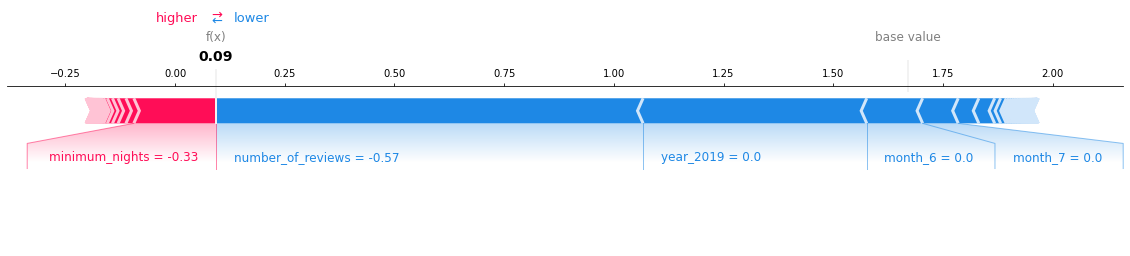

In [46]:
# Round shapley values for ease of visualization
X_test_enc = X_test_enc.round(2)

shap.initjs()
shap.force_plot(
    lgbm_explainer.expected_value,
    test_lgbm_shap_values[3],
    X_test_enc.iloc[3, :], 
    matplotlib=True,
)

In [47]:
true_3 = y_test.iloc[3]
true_3

0.02

_From the above graphic and calculations we can see that the base value (average value) for the target is 1.33. Our true target value for the test sample number 3 is 0.02 and our model has predicted a value of 0.06. The major negative forces (feature values) driving this prediction towards 0.06 are `number_of_reviews`, `year_2019`, `month_6`, and `month_7`. The major positive force (feature value) pushing the prediction to its current value is `minimum_nights`._

<br><br>

## 13. Summary of results 
<hr>

Imagine that you want to present the summary of these results to your boss and co-workers. 

1. Create a table summarizing important results. 
2. Write concluding remarks.
3. Discuss other ideas that you did not try but could potentially improve the performance/interpretability . 
3. Report your final test score along with the metric you used at the top of this notebook in the [Submission instructions section](#si).

In [48]:
re_col = [
    "Dummy Regressor",
    "Ridge",
    "Tuned Ridge",
    "SVR",
    "Tuned SVR",
    "Random Forest",
    "Tuned RF",
    "LGBM Regressor",
    "Tuned LGBM",
]
summary = pd.DataFrame(results).reindex(columns=re_col)
summary

Dummy Regressor               Ridge         Tuned Ridge  \
fit_time      0.171 (+/- 0.010)   0.209 (+/- 0.011)   0.184 (+/- 0.007)   
score_time    0.041 (+/- 0.013)   0.051 (+/- 0.017)   0.043 (+/- 0.002)   
test_score   -1.666 (+/- 0.072)  -1.132 (+/- 0.033)  -1.123 (+/- 0.036)   
train_score  -1.666 (+/- 0.018)  -1.081 (+/- 0.008)  -1.087 (+/- 0.009)   

                            SVR           Tuned SVR       Random Forest  \
fit_time      7.625 (+/- 0.294)  30.532 (+/- 1.257)  59.708 (+/- 2.582)   
score_time    1.424 (+/- 0.101)   1.623 (+/- 0.139)   0.100 (+/- 0.009)   
test_score   -1.102 (+/- 0.056)  -1.081 (+/- 0.045)  -1.002 (+/- 0.058)   
train_score  -0.976 (+/- 0.013)  -0.534 (+/- 0.019)  -0.373 (+/- 0.008)   

                       Tuned RF      LGBM Regressor          Tuned LGBM  
fit_time     16.917 (+/- 0.332)   0.448 (+/- 0.059)   0.578 (+/- 0.009)  
score_time    0.076 (+/- 0.005)   0.125 (+/- 0.010)   0.130 (+/- 0.006)  
test_score   -1.004 (+/- 0.053)  -0.987 (+/- 0.048)  -0.987 (+/- 0.044)  
train_score  -0.772 (+/- 0.009)  -0.770 (+/- 0.007)  -0.849 (+/- 0.010)

Since I was dealing with a regression problem, I used a Dummy Regressor as my baseline, and selected Root Mean Square Error (RMSE) as my scoring metric. I got a RMSE baseline of 1.66. I then tried two simple models of Linear regression (Ridge) and Support Vector Machine (SVR) and tried tuning the models to see if I could improve the score. Although SVR was giving me a better score than Ridge, it was a slow model. Therefore, I selected two tree-based models of RandomForeset Regressor and LGBM Regressor to see if I could improve speed and also performance. Although they both gave me better scores, Random Forest was even slower than SVR, and was suffering from overfitting. LGBM was not only giving me a better score, but also much faster than the other two. As my chosen final model, I did hyperparameter tuning and feature selection on LGBM Regressor which did not change my mean CV RMSE a lot.

<br><br><br>

## 14. Other Ideas - Future Improvements

This data set was already large and in order to compensate for lack of resources on my computer, I allocated a higher percentage of the original data to test set. I could try giving a larger percentage to the train data on a stronger computer to see if my scores would improve. Although I created 3 extra features which proved to be useful, I could have allocated more time to feature engineering. Also, I used RFECV which was very resource incentive taking away the opportunity (time) to try out ensemble models. Instead, I could have used a faster method like SelectFromModel using lasso to see if I could do some faster feature selection using L1 regularization. With this I could even try feature selection on more interpretable models like Ridge to see if I could improve the performance. Last but not the least, I did not try any ensemble models which could be a future addition to the project._  
_As a proof of concept for time saving, below I have added SelectFromModel with Lasso as a feature selection step. This only took only a fraction of time (less than 1s average fit time versus 416s average fit time) when compared to the RFECV feature selection! Also, using Lasso we see an over 1 percent improvement in RMSE while RFECV inscrased RMSE._

In [49]:
lgbm_lasso_pipe = make_pipeline(
    preprocessor,
    SelectFromModel(Lasso(alpha=0.001, max_iter=100000)),
    LGBMRegressor(
            random_state=2021,
            verbose=0,
            force_col_wise=True,
        )
)

In [50]:
summary["LGBM Feature Selection"] = mean_std_cross_val_scores(lgbm_lasso_pipe, X_train, y_train, return_train_score=True, cv=5, scoring=scoring)
pd.DataFrame(summary)

Dummy Regressor               Ridge         Tuned Ridge  \
fit_time      0.171 (+/- 0.010)   0.209 (+/- 0.011)   0.184 (+/- 0.007)   
score_time    0.041 (+/- 0.013)   0.051 (+/- 0.017)   0.043 (+/- 0.002)   
test_score   -1.666 (+/- 0.072)  -1.132 (+/- 0.033)  -1.123 (+/- 0.036)   
train_score  -1.666 (+/- 0.018)  -1.081 (+/- 0.008)  -1.087 (+/- 0.009)   

                            SVR           Tuned SVR       Random Forest  \
fit_time      7.625 (+/- 0.294)  30.532 (+/- 1.257)  59.708 (+/- 2.582)   
score_time    1.424 (+/- 0.101)   1.623 (+/- 0.139)   0.100 (+/- 0.009)   
test_score   -1.102 (+/- 0.056)  -1.081 (+/- 0.045)  -1.002 (+/- 0.058)   
train_score  -0.976 (+/- 0.013)  -0.534 (+/- 0.019)  -0.373 (+/- 0.008)   

                       Tuned RF      LGBM Regressor          Tuned LGBM  \
fit_time     16.917 (+/- 0.332)   0.448 (+/- 0.059)   0.578 (+/- 0.009)   
score_time    0.076 (+/- 0.005)   0.125 (+/- 0.010)   0.130 (+/- 0.006)   
test_score   -1.004 (+/- 0.053)  -0.987 (+/- 0.048)  -0.987 (+/- 0.044)   
train_score  -0.772 (+/- 0.009)  -0.770 (+/- 0.007)  -0.849 (+/- 0.010)   

            LGBM Feature Selection  
fit_time         1.282 (+/- 0.173)  
score_time       0.127 (+/- 0.015)  
test_score      -0.987 (+/- 0.045)  
train_score     -0.772 (+/- 0.009)

<br><br>

<br><br>